In [1]:
import numpy as np
import tensorflow as tf
import gzip
import pickle
import sys
import copy
import os.path
import pdb
import re
from run_split import SplitMnistGenerator, SplitMnistRandomGenerator, SplitMnistBackgroundGenerator
from run_not import NotMnistGenerator
from alg.cla_models_multihead import Vanilla_NN
from alg.IBP_BNN_multihead import IBP_NN
from alg.utils import get_scores, concatenate_results
from alg.vcl import run_vcl
from copy import deepcopy

from bayes_opt import BayesianOptimization

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

W1101 10:13:59.640777 140387104425792 deprecation_wrapper.py:119] From alg/cla_models_multihead.py:9: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



# Split MNIST

In [3]:
hidden_size = [100]
batch_size = 128
no_epochs = 500
alpha0 = 5.0
tau0=1.0 # initial temperature
ANNEAL_RATE=0.000
MIN_TEMP=0.1
ibp_samples = 10
learning_rate=0.0001

# Run vanilla VCL
tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
val = True
data_gen = SplitMnistGenerator(val)
single_head=True
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
x_valsets, y_valsets = [], []
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()
    if val:
        x_train, y_train, x_test, y_test, x_val, y_val = data_gen.next_task()
        x_valsets.append(x_val)
        y_valsets.append(y_val)
    else:    
        x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, no_epochs, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = IBP_NN(in_dim, hidden_size, out_dim, x_train.shape[0], num_ibp_samples=ibp_samples,
                           prev_means=mf_weights, 
                           prev_log_variances=mf_variances, prev_betas=mf_betas,alpha0=alpha0,
                           learning_rate=learning_rate, lambda_1=tau0, lambda_2=1.0, no_pred_samples=100,
                           name='ibp_sh_local', use_local_reparam=True)
    mf_model.train(x_train, y_train, head, no_epochs, bsize,
                   anneal_rate=ANNEAL_RATE, min_temp=MIN_TEMP)
    mf_weights, mf_variances, mf_betas = mf_model.get_weights()

    acc = get_scores(mf_model, x_valsets, y_valsets, single_head)
    ibp_acc = concatenate_results(acc, ibp_acc)
    
    mf_model.close_session()
    
ibp_acc

Epoch: 0001 cost= 0.081253377
Epoch: 0006 cost= 0.001269883
Epoch: 0011 cost= 0.000307857
Epoch: 0016 cost= 0.000124624
Epoch: 0021 cost= 0.000067133
Epoch: 0026 cost= 0.000040432
Epoch: 0031 cost= 0.000025726
Epoch: 0036 cost= 0.000016784
Epoch: 0041 cost= 0.000011895
Epoch: 0046 cost= 0.000008346
Epoch: 0051 cost= 0.000005989
Epoch: 0056 cost= 0.000004473
Epoch: 0061 cost= 0.000003361
Epoch: 0066 cost= 0.000002537
Epoch: 0071 cost= 0.000001956
Epoch: 0076 cost= 0.000001485
Epoch: 0081 cost= 0.000001158
Epoch: 0086 cost= 0.000000881
Epoch: 0091 cost= 0.000000686
Epoch: 0096 cost= 0.000000535
Epoch: 0101 cost= 0.000000412
Epoch: 0106 cost= 0.000000328
Epoch: 0111 cost= 0.000000256
Epoch: 0116 cost= 0.000000204
Epoch: 0121 cost= 0.000000159
Epoch: 0126 cost= 0.000000126
Epoch: 0131 cost= 0.000000098
Epoch: 0136 cost= 0.000000078
Epoch: 0141 cost= 0.000000063
Epoch: 0146 cost= 0.000000050
Epoch: 0151 cost= 0.000000039
Epoch: 0156 cost= 0.000000032
Epoch: 0161 cost= 0.000000025
Epoch: 016

W1101 10:15:29.891782 140387104425792 deprecation.py:323] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:682: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


(1, ?, 100)


W1101 10:15:30.153161 140387104425792 deprecation.py:323] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:634: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


(1, ?, 100)
(1, ?, 100)


W1101 10:15:30.762429 140387104425792 deprecation.py:323] From /home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1101 10:15:31.661540 140387104425792 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:641: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W1101 10:15:31.723825 140387104425792 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:818: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



Z: (1, ?, 100)
Epoch: 0001 train cost= 19.975376313
Epoch: 0006 train cost= 19.571693237
Epoch: 0011 train cost= 19.281420030
Epoch: 0016 train cost= 19.031923340
Epoch: 0021 train cost= 18.805110242
Epoch: 0026 train cost= 18.604282701
Epoch: 0031 train cost= 18.420960070
Epoch: 0036 train cost= 18.242488401
Epoch: 0041 train cost= 18.079205708
Epoch: 0046 train cost= 17.916179795
Epoch: 0051 train cost= 17.763693338
Epoch: 0056 train cost= 17.606023398
Epoch: 0061 train cost= 17.449779005
Epoch: 0066 train cost= 17.295334437
Epoch: 0071 train cost= 17.143068566
Epoch: 0076 train cost= 16.984845150
Epoch: 0081 train cost= 16.831616482
Epoch: 0086 train cost= 16.675121514
Epoch: 0091 train cost= 16.517931950
Epoch: 0096 train cost= 16.359591955
Epoch: 0101 train cost= 16.205291978
Epoch: 0106 train cost= 16.048283221
Epoch: 0111 train cost= 15.891649533
Epoch: 0116 train cost= 15.740216117
Epoch: 0121 train cost= 15.582627296
Epoch: 0126 train cost= 15.428376290
Epoch: 0131 train cost=

Epoch: 0116 train cost= 0.464056182
Epoch: 0121 train cost= 0.461434723
Epoch: 0126 train cost= 0.457988574
Epoch: 0131 train cost= 0.459501675
Epoch: 0136 train cost= 0.459376675
Epoch: 0141 train cost= 0.458035605
Epoch: 0146 train cost= 0.453730491
Epoch: 0151 train cost= 0.454912692
Epoch: 0156 train cost= 0.452500133
Epoch: 0161 train cost= 0.451236711
Epoch: 0166 train cost= 0.449894167
Epoch: 0171 train cost= 0.449694142
Epoch: 0176 train cost= 0.447777812
Epoch: 0181 train cost= 0.448967346
Epoch: 0186 train cost= 0.448388050
Epoch: 0191 train cost= 0.443048757
Epoch: 0196 train cost= 0.443984464
Epoch: 0201 train cost= 0.442342249
Epoch: 0206 train cost= 0.442046234
Epoch: 0211 train cost= 0.440218507
Epoch: 0216 train cost= 0.441963513
Epoch: 0221 train cost= 0.438367999
Epoch: 0226 train cost= 0.437563683
Epoch: 0231 train cost= 0.435872588
Epoch: 0236 train cost= 0.436795609
Epoch: 0241 train cost= 0.436771648
Epoch: 0246 train cost= 0.435758433
Epoch: 0251 train cost= 0.43

Epoch: 0241 train cost= 0.362985484
Epoch: 0246 train cost= 0.357383865
Epoch: 0251 train cost= 0.359720403
Epoch: 0256 train cost= 0.359380542
Epoch: 0261 train cost= 0.356255830
Epoch: 0266 train cost= 0.359642401
Epoch: 0271 train cost= 0.357087785
Epoch: 0276 train cost= 0.359069880
Epoch: 0281 train cost= 0.354684896
Epoch: 0286 train cost= 0.356275870
Epoch: 0291 train cost= 0.353696061
Epoch: 0296 train cost= 0.356053420
Epoch: 0301 train cost= 0.351208126
Epoch: 0306 train cost= 0.351086499
Epoch: 0311 train cost= 0.350914888
Epoch: 0316 train cost= 0.352919271
Epoch: 0321 train cost= 0.350065221
Epoch: 0326 train cost= 0.348772600
Epoch: 0331 train cost= 0.347152328
Epoch: 0336 train cost= 0.349637581
Epoch: 0341 train cost= 0.348499156
Epoch: 0346 train cost= 0.345119556
Epoch: 0351 train cost= 0.349706652
Epoch: 0356 train cost= 0.346418746
Epoch: 0361 train cost= 0.346379617
Epoch: 0366 train cost= 0.345676919
Epoch: 0371 train cost= 0.343021952
Epoch: 0376 train cost= 0.34

array([[0.99951338,        nan,        nan,        nan,        nan],
       [0.7946472 , 0.98316832,        nan,        nan,        nan],
       [0.45498783, 0.86485149, 0.98946259,        nan,        nan],
       [0.75279805, 0.85148515, 0.61591149, 0.99805542,        nan],
       [0.35912409, 0.67227723, 0.20073762, 0.95041322, 0.97969543]])

In [4]:
# Run Vanilla VCL
tf.reset_default_graph()
tf.set_random_seed(12)
np.random.seed(1)
hidden_size = [10]
coreset_size = 0
single_head=True
data_gen = SplitMnistGenerator(val=True)
vcl_result_h10, uncerts_h10 = run_vcl(hidden_size, no_epochs, data_gen, 
                              lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result_h10)

Epoch: 0001 cost= 0.386311521
Epoch: 0006 cost= 0.004784805
Epoch: 0011 cost= 0.002304074
Epoch: 0016 cost= 0.001370307
Epoch: 0021 cost= 0.000747599
Epoch: 0026 cost= 0.000431967
Epoch: 0031 cost= 0.000288702
Epoch: 0036 cost= 0.000185143
Epoch: 0041 cost= 0.000131790
Epoch: 0046 cost= 0.000092592
Epoch: 0051 cost= 0.000066083
Epoch: 0056 cost= 0.000049419
Epoch: 0061 cost= 0.000037379
Epoch: 0066 cost= 0.000028381
Epoch: 0071 cost= 0.000022086
Epoch: 0076 cost= 0.000016908
Epoch: 0081 cost= 0.000013344
Epoch: 0086 cost= 0.000010333
Epoch: 0091 cost= 0.000008103
Epoch: 0096 cost= 0.000006304
Epoch: 0101 cost= 0.000004917
Epoch: 0106 cost= 0.000003942
Epoch: 0111 cost= 0.000003034
Epoch: 0116 cost= 0.000002459
Epoch: 0121 cost= 0.000001925
Epoch: 0126 cost= 0.000001514
Epoch: 0131 cost= 0.000001178
Epoch: 0136 cost= 0.000000943
Epoch: 0141 cost= 0.000000762
Epoch: 0146 cost= 0.000000609
Epoch: 0151 cost= 0.000000471
Epoch: 0156 cost= 0.000000383
Epoch: 0161 cost= 0.000000302
Epoch: 016

W1101 11:11:53.728910 140387104425792 deprecation_wrapper.py:119] From alg/cla_models_multihead.py:524: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



New model, training
Epoch: 0001 cost= 1.850908252
Epoch: 0006 cost= 1.690037062
Epoch: 0011 cost= 1.536525104
Epoch: 0016 cost= 1.384254675
Epoch: 0021 cost= 1.233175276
Epoch: 0026 cost= 1.083620081
Epoch: 0031 cost= 0.936727764
Epoch: 0036 cost= 0.792882271
Epoch: 0041 cost= 0.653747439
Epoch: 0046 cost= 0.521979626
Epoch: 0051 cost= 0.399761798
Epoch: 0056 cost= 0.290982949
Epoch: 0061 cost= 0.197957295
Epoch: 0066 cost= 0.126046562
Epoch: 0071 cost= 0.075246767
Epoch: 0076 cost= 0.046929400
Epoch: 0081 cost= 0.032695258
Epoch: 0086 cost= 0.027805843
Epoch: 0091 cost= 0.025963226
Epoch: 0096 cost= 0.025278911
Epoch: 0101 cost= 0.025421794
Epoch: 0106 cost= 0.023970616
Epoch: 0111 cost= 0.023879872
Epoch: 0116 cost= 0.024592419
Epoch: 0121 cost= 0.023336294
Epoch: 0126 cost= 0.024104920
Epoch: 0131 cost= 0.023737731
Epoch: 0136 cost= 0.024030846
Epoch: 0141 cost= 0.023484259
Epoch: 0146 cost= 0.023701175
Epoch: 0151 cost= 0.022602371
Epoch: 0156 cost= 0.022956774
Epoch: 0161 cost= 0.

Epoch: 0361 cost= 0.052357775
Epoch: 0366 cost= 0.051827697
Epoch: 0371 cost= 0.051858580
Epoch: 0376 cost= 0.051222906
Epoch: 0381 cost= 0.052428261
Epoch: 0386 cost= 0.052262205
Epoch: 0391 cost= 0.051144149
Epoch: 0396 cost= 0.052108192
Epoch: 0401 cost= 0.051826164
Epoch: 0406 cost= 0.052237567
Epoch: 0411 cost= 0.053314216
Epoch: 0416 cost= 0.051943304
Epoch: 0421 cost= 0.051483409
Epoch: 0426 cost= 0.052974756
Epoch: 0431 cost= 0.051740697
Epoch: 0436 cost= 0.052778949
Epoch: 0441 cost= 0.052064472
Epoch: 0446 cost= 0.052413550
Epoch: 0451 cost= 0.051349503
Epoch: 0456 cost= 0.051433271
Epoch: 0461 cost= 0.053099441
Epoch: 0466 cost= 0.052234572
Epoch: 0471 cost= 0.052365623
Epoch: 0476 cost= 0.051006756
Epoch: 0481 cost= 0.051152127
Epoch: 0486 cost= 0.052036914
Epoch: 0491 cost= 0.051486337
Epoch: 0496 cost= 0.052649186
New model, training
Epoch: 0001 cost= 1.891867772
Epoch: 0006 cost= 0.139081428
Epoch: 0011 cost= 0.083184475
Epoch: 0016 cost= 0.069715730
Epoch: 0021 cost= 0.

In [6]:
# Run Vanilla VCL
tf.reset_default_graph()
tf.set_random_seed(12)
np.random.seed(1)
hidden_size = [5]
coreset_size = 0
single_head=True
data_gen = SplitMnistGenerator(val=True)
vcl_result_h5, uncerts_h5 = run_vcl(hidden_size, no_epochs, data_gen, 
                              lambda a: a, coreset_size, batch_size, single_head, val=True, name='split_mnist_h5')
print(vcl_result_h5)

Epoch: 0001 cost= 0.339536600
Epoch: 0006 cost= 0.006561522
Epoch: 0011 cost= 0.003361302
Epoch: 0016 cost= 0.002288341
Epoch: 0021 cost= 0.001596628
Epoch: 0026 cost= 0.001129159
Epoch: 0031 cost= 0.000813540
Epoch: 0036 cost= 0.000557973
Epoch: 0041 cost= 0.000406141
Epoch: 0046 cost= 0.000291554
Epoch: 0051 cost= 0.000209063
Epoch: 0056 cost= 0.000156946
Epoch: 0061 cost= 0.000117837
Epoch: 0066 cost= 0.000091104
Epoch: 0071 cost= 0.000070772
Epoch: 0076 cost= 0.000052777
Epoch: 0081 cost= 0.000042875
Epoch: 0086 cost= 0.000032212
Epoch: 0091 cost= 0.000025172
Epoch: 0096 cost= 0.000019757
Epoch: 0101 cost= 0.000015342
Epoch: 0106 cost= 0.000012192
Epoch: 0111 cost= 0.000009639
Epoch: 0116 cost= 0.000007777
Epoch: 0121 cost= 0.000006061
Epoch: 0126 cost= 0.000004769
Epoch: 0131 cost= 0.000003685
Epoch: 0136 cost= 0.000002930
Epoch: 0141 cost= 0.000002404
Epoch: 0146 cost= 0.000001907
Epoch: 0151 cost= 0.000001499
Epoch: 0156 cost= 0.000001196
Epoch: 0161 cost= 0.000000935
Epoch: 016

Epoch: 0361 cost= 0.118683459
Epoch: 0366 cost= 0.119558160
Epoch: 0371 cost= 0.120827516
Epoch: 0376 cost= 0.118697614
Epoch: 0381 cost= 0.120978376
Epoch: 0386 cost= 0.118117642
Epoch: 0391 cost= 0.118688928
Epoch: 0396 cost= 0.119058818
Epoch: 0401 cost= 0.118940660
Epoch: 0406 cost= 0.118406490
Epoch: 0411 cost= 0.119810877
Epoch: 0416 cost= 0.119745208
Epoch: 0421 cost= 0.118994373
Epoch: 0426 cost= 0.119822464
Epoch: 0431 cost= 0.118726356
Epoch: 0436 cost= 0.119308504
Epoch: 0441 cost= 0.119975186
Epoch: 0446 cost= 0.117802258
Epoch: 0451 cost= 0.118165221
Epoch: 0456 cost= 0.119078515
Epoch: 0461 cost= 0.118881753
Epoch: 0466 cost= 0.119163450
Epoch: 0471 cost= 0.119377203
Epoch: 0476 cost= 0.118695538
Epoch: 0481 cost= 0.118955151
Epoch: 0486 cost= 0.119572109
Epoch: 0491 cost= 0.119130504
Epoch: 0496 cost= 0.118732643
New model, training
Epoch: 0001 cost= 0.611744769
Epoch: 0006 cost= 0.183729244
Epoch: 0011 cost= 0.099836699
Epoch: 0016 cost= 0.075927996
Epoch: 0021 cost= 0.

Epoch: 0221 cost= 0.091588987
Epoch: 0226 cost= 0.091870217
Epoch: 0231 cost= 0.091231377
Epoch: 0236 cost= 0.091295155
Epoch: 0241 cost= 0.091502976
Epoch: 0246 cost= 0.092004002
Epoch: 0251 cost= 0.091242321
Epoch: 0256 cost= 0.091137178
Epoch: 0261 cost= 0.091114212
Epoch: 0266 cost= 0.091746441
Epoch: 0271 cost= 0.091890495
Epoch: 0276 cost= 0.091163066
Epoch: 0281 cost= 0.091084686
Epoch: 0286 cost= 0.091402658
Epoch: 0291 cost= 0.092462375
Epoch: 0296 cost= 0.092079578
Epoch: 0301 cost= 0.091958202
Epoch: 0306 cost= 0.091905602
Epoch: 0311 cost= 0.092268757
Epoch: 0316 cost= 0.091786225
Epoch: 0321 cost= 0.091684766
Epoch: 0326 cost= 0.091034193
Epoch: 0331 cost= 0.092136963
Epoch: 0336 cost= 0.091598559
Epoch: 0341 cost= 0.090529044
Epoch: 0346 cost= 0.091879021
Epoch: 0351 cost= 0.091410976
Epoch: 0356 cost= 0.091299928
Epoch: 0361 cost= 0.091403895
Epoch: 0366 cost= 0.091369588
Epoch: 0371 cost= 0.090997291
Epoch: 0376 cost= 0.091571034
Epoch: 0381 cost= 0.092048227
Epoch: 038

In [7]:
# Run Vanilla VCL
tf.reset_default_graph()
tf.set_random_seed(12)
np.random.seed(1)
hidden_size = [50]
coreset_size = 0
single_head=True
data_gen = SplitMnistGenerator(val=True)
vcl_result_h50, uncerts_h50 = run_vcl(hidden_size, no_epochs, data_gen, 
                         lambda a: a, coreset_size, batch_size, single_head, val=True, 
                         name='split_mnist_h50')
print(vcl_result_h50)

Epoch: 0001 cost= 0.101363720
Epoch: 0006 cost= 0.001936481
Epoch: 0011 cost= 0.000634408
Epoch: 0016 cost= 0.000239112
Epoch: 0021 cost= 0.000122146
Epoch: 0026 cost= 0.000073427
Epoch: 0031 cost= 0.000048576
Epoch: 0036 cost= 0.000031132
Epoch: 0041 cost= 0.000022376
Epoch: 0046 cost= 0.000015526
Epoch: 0051 cost= 0.000011160
Epoch: 0056 cost= 0.000008391
Epoch: 0061 cost= 0.000006302
Epoch: 0066 cost= 0.000004804
Epoch: 0071 cost= 0.000003690
Epoch: 0076 cost= 0.000002817
Epoch: 0081 cost= 0.000002216
Epoch: 0086 cost= 0.000001703
Epoch: 0091 cost= 0.000001333
Epoch: 0096 cost= 0.000001043
Epoch: 0101 cost= 0.000000810
Epoch: 0106 cost= 0.000000645
Epoch: 0111 cost= 0.000000503
Epoch: 0116 cost= 0.000000405
Epoch: 0121 cost= 0.000000316
Epoch: 0126 cost= 0.000000249
Epoch: 0131 cost= 0.000000195
Epoch: 0136 cost= 0.000000155
Epoch: 0141 cost= 0.000000125
Epoch: 0146 cost= 0.000000099
Epoch: 0151 cost= 0.000000078
Epoch: 0156 cost= 0.000000063
Epoch: 0161 cost= 0.000000050
Epoch: 016

Epoch: 0361 cost= 0.146735244
Epoch: 0366 cost= 0.147372226
Epoch: 0371 cost= 0.149244395
Epoch: 0376 cost= 0.145173972
Epoch: 0381 cost= 0.147367439
Epoch: 0386 cost= 0.147872846
Epoch: 0391 cost= 0.146799851
Epoch: 0396 cost= 0.147446159
Epoch: 0401 cost= 0.145822597
Epoch: 0406 cost= 0.147777278
Epoch: 0411 cost= 0.147709277
Epoch: 0416 cost= 0.147069307
Epoch: 0421 cost= 0.147218757
Epoch: 0426 cost= 0.146533954
Epoch: 0431 cost= 0.148674603
Epoch: 0436 cost= 0.147798694
Epoch: 0441 cost= 0.146595943
Epoch: 0446 cost= 0.146150174
Epoch: 0451 cost= 0.148891491
Epoch: 0456 cost= 0.147287165
Epoch: 0461 cost= 0.147028596
Epoch: 0466 cost= 0.146853542
Epoch: 0471 cost= 0.146515570
Epoch: 0476 cost= 0.147908833
Epoch: 0481 cost= 0.146116297
Epoch: 0486 cost= 0.147281278
Epoch: 0491 cost= 0.146964909
Epoch: 0496 cost= 0.146730532
New model, training
Epoch: 0001 cost= 0.953030892
Epoch: 0006 cost= 0.219392786
Epoch: 0011 cost= 0.144632668
Epoch: 0016 cost= 0.124216277
Epoch: 0021 cost= 0.

Epoch: 0221 cost= 0.089153323
Epoch: 0226 cost= 0.088296601
Epoch: 0231 cost= 0.088674708
Epoch: 0236 cost= 0.088051406
Epoch: 0241 cost= 0.087552071
Epoch: 0246 cost= 0.088033040
Epoch: 0251 cost= 0.087145121
Epoch: 0256 cost= 0.087567529
Epoch: 0261 cost= 0.087313096
Epoch: 0266 cost= 0.086700414
Epoch: 0271 cost= 0.085402601
Epoch: 0276 cost= 0.087358837
Epoch: 0281 cost= 0.087685448
Epoch: 0286 cost= 0.086007976
Epoch: 0291 cost= 0.084139225
Epoch: 0296 cost= 0.086420468
Epoch: 0301 cost= 0.085251375
Epoch: 0306 cost= 0.085551193
Epoch: 0311 cost= 0.085178387
Epoch: 0316 cost= 0.085066774
Epoch: 0321 cost= 0.084489987
Epoch: 0326 cost= 0.084056474
Epoch: 0331 cost= 0.083996445
Epoch: 0336 cost= 0.083989854
Epoch: 0341 cost= 0.084011854
Epoch: 0346 cost= 0.083506820
Epoch: 0351 cost= 0.084284789
Epoch: 0356 cost= 0.083779852
Epoch: 0361 cost= 0.083579996
Epoch: 0366 cost= 0.082803081
Epoch: 0371 cost= 0.083397622
Epoch: 0376 cost= 0.084134508
Epoch: 0381 cost= 0.083390967
Epoch: 038

In [12]:
vcl_result_h10

(array([[0.99952719,        nan,        nan,        nan,        nan],
        [0.74609929, 0.99020568,        nan,        nan,        nan],
        [0.35744681, 0.90940255, 0.99893276,        nan,        nan],
        [0.75886525, 0.86679726, 0.54909285, 0.99647533,        nan],
        [0.31489362, 0.66062684, 0.17395945, 0.94914401, 0.98940998]]),
 array([[0.00480255, 0.23689461, 0.21379979, 0.18195859, 0.23028301],
        [0.08733767, 0.0260357 , 0.10167336, 0.13172103, 0.13562647],
        [0.15967427, 0.08263793, 0.01419958, 0.11671524, 0.10913388],
        [0.16762707, 0.0933582 , 0.18446559, 0.00986795, 0.11867216],
        [0.09552615, 0.06818037, 0.07950181, 0.05968044, 0.01842505]]))

In [13]:
_ibp_acc = np.nanmean(ibp_acc, 1) # each row is averaged!
_vcl_result_h10 = np.nanmean(vcl_result_h10[0], 1)
_vcl_result_h5 = np.nanmean(vcl_result_h5[0], 1)
_vcl_result_h50 = np.nanmean(vcl_result_h50[0], 1)

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


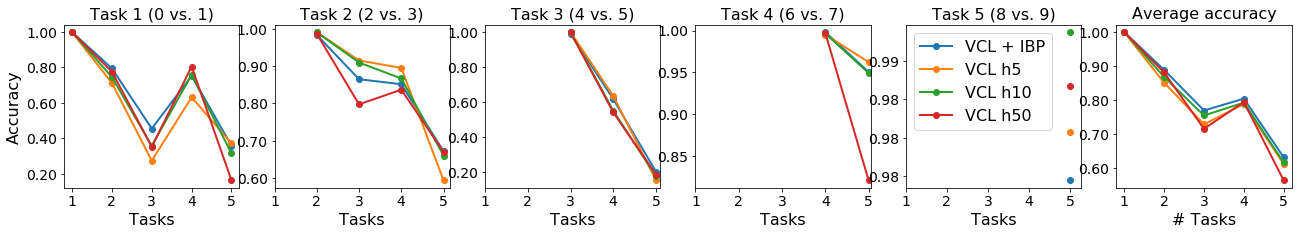

In [24]:
# fig = plt.figure(figsize=(7,4))
# ax = plt.gca()
# plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
# plt.plot(np.arange(len(_ibp_acc))+1, _vcl_result_h5, label='VCL h5', marker='o')
# plt.plot(np.arange(len(_ibp_acc))+1, _vcl_result_h10, label='VCL h10', marker='o')
# plt.plot(np.arange(len(_ibp_acc))+1, _vcl_result_h50, label='VCL h50', marker='o')
# ax.set_xticks(range(1, len(_ibp_acc)+1))
# ax.set_ylabel('Average accuracy')
# ax.set_xlabel('\# tasks')
# ax.legend()
# fig.show()

from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, vcl_result_h5[0][:, i], label='VCL h5', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, vcl_result_h10[0][:, i], label='VCL h10', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, vcl_result_h50[0][:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(ibp_acc[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[i].tick_params(labelsize=tick_size)
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
ax[5].plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(_ibp_acc))+1, _vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(_ibp_acc))+1, _vcl_result_h10, label='VCL h10', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(_ibp_acc))+1, _vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax[5].legend()
#plt.savefig(\"plots/perm_mnist_all.pdf\", bbox_inches='tight')
fig.show()

In [25]:
print(np.nanmean(ibp_acc))
print(np.nanmean(vcl_result_h10[0]))
print(np.nanmean(vcl_result_h5[0]))
print(np.nanmean(vcl_result_h50[0]))

0.7644752339652715
0.7507252567647148
0.740582552990661
0.727633876354717


In [56]:
with open('results/split_mnist_sh.pkl', 'wb') as input_file:
    pickle.dump({'vcl_ibp': ibp_acc,
                 'vcl_h10': vcl_result,
                 'vcl_h5': vcl_result_h5,
                 'vcl_h50': vcl_result_h50}, input_file)

# Not MNIST

In [57]:
hidden_size = [100]
batch_size = 128
no_epochs = 500
ibp_samples = 10
learning_rate=0.0001

# Run vanilla VCL
tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
data_gen = NotMnistGenerator()
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
#x_valsets, y_valsets = [], []
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()
    x_train, y_train, x_test, y_test, _, _ = data_gen.next_task()
    #x_valsets.append(x_val)
    #y_valsets.append(y_val)
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, no_epochs, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = IBP_NN(in_dim, hidden_size, out_dim, x_train.shape[0], num_ibp_samples=ibp_samples,
                           prev_means=mf_weights, 
                           prev_log_variances=mf_variances, prev_betas=mf_betas, 
                           alpha0=5., beta0=1.,
                           learning_rate=learning_rate, lambda_1=1.0, lambda_2=1.0, no_pred_samples=100,
                          name='ibp_not')

    mf_model.train(x_train, y_train, head, no_epochs, bsize,
                   anneal_rate=0.0, min_temp=1.0)
    mf_weights, mf_variances, mf_betas = mf_model.get_weights()

    acc = get_scores(mf_model, x_testsets, y_testsets, single_head)
    ibp_acc = concatenate_results(acc, ibp_acc)
    
    mf_model.close_session()
    
ibp_acc

Epoch: 0001 cost= 0.147950740
Epoch: 0006 cost= 0.052100334
Epoch: 0011 cost= 0.027261425
Epoch: 0016 cost= 0.016392342
Epoch: 0021 cost= 0.012724730
Epoch: 0026 cost= 0.011206084
Epoch: 0031 cost= 0.010892851
Epoch: 0036 cost= 0.008530463
Epoch: 0041 cost= 0.008514597
Epoch: 0046 cost= 0.007187106
Epoch: 0051 cost= 0.008457751
Epoch: 0056 cost= 0.008551123
Epoch: 0061 cost= 0.007755257
Epoch: 0066 cost= 0.006361756
Epoch: 0071 cost= 0.004637599
Epoch: 0076 cost= 0.007298294
Epoch: 0081 cost= 0.007662674
Epoch: 0086 cost= 0.007053139
Epoch: 0091 cost= 0.007399848
Epoch: 0096 cost= 0.005222385
Epoch: 0101 cost= 0.006111367
Epoch: 0106 cost= 0.004928066
Epoch: 0111 cost= 0.007485502
Epoch: 0116 cost= 0.003434861
Epoch: 0121 cost= 0.006662809
Epoch: 0126 cost= 0.004171039
Epoch: 0131 cost= 0.004220554
Epoch: 0136 cost= 0.004703483
Epoch: 0141 cost= 0.004993734
Epoch: 0146 cost= 0.007615835
Epoch: 0151 cost= 0.005706291
Epoch: 0156 cost= 0.004756697
Epoch: 0161 cost= 0.005239427
Epoch: 016

Epoch: 0196 train cost= 0.185035757
Epoch: 0201 train cost= 0.185209169
Epoch: 0206 train cost= 0.184903419
Epoch: 0211 train cost= 0.184326771
Epoch: 0216 train cost= 0.183576571
Epoch: 0221 train cost= 0.183911950
Epoch: 0226 train cost= 0.183465574
Epoch: 0231 train cost= 0.184351507
Epoch: 0236 train cost= 0.183443937
Epoch: 0241 train cost= 0.182108271
Epoch: 0246 train cost= 0.183971417
Epoch: 0251 train cost= 0.182951321
Epoch: 0256 train cost= 0.183142166
Epoch: 0261 train cost= 0.182533150
Epoch: 0266 train cost= 0.182967111
Epoch: 0271 train cost= 0.181919298
Epoch: 0276 train cost= 0.182287182
Epoch: 0281 train cost= 0.182250887
Epoch: 0286 train cost= 0.181154738
Epoch: 0291 train cost= 0.180891431
Epoch: 0296 train cost= 0.181709207
Epoch: 0301 train cost= 0.182257229
Epoch: 0306 train cost= 0.181270699
Epoch: 0311 train cost= 0.181120714
Epoch: 0316 train cost= 0.180711877
Epoch: 0321 train cost= 0.180880935
Epoch: 0326 train cost= 0.180626418
Epoch: 0331 train cost= 0.18

Epoch: 0306 train cost= 0.207066099
Epoch: 0311 train cost= 0.207180830
Epoch: 0316 train cost= 0.206017970
Epoch: 0321 train cost= 0.207037361
Epoch: 0326 train cost= 0.207184487
Epoch: 0331 train cost= 0.205552724
Epoch: 0336 train cost= 0.206246939
Epoch: 0341 train cost= 0.206282117
Epoch: 0346 train cost= 0.206240387
Epoch: 0351 train cost= 0.206702051
Epoch: 0356 train cost= 0.205680377
Epoch: 0361 train cost= 0.206088974
Epoch: 0366 train cost= 0.205819563
Epoch: 0371 train cost= 0.206562018
Epoch: 0376 train cost= 0.206553730
Epoch: 0381 train cost= 0.206043332
Epoch: 0386 train cost= 0.206292624
Epoch: 0391 train cost= 0.205590546
Epoch: 0396 train cost= 0.206216920
Epoch: 0401 train cost= 0.205930121
Epoch: 0406 train cost= 0.205879759
Epoch: 0411 train cost= 0.205626552
Epoch: 0416 train cost= 0.204384129
Epoch: 0421 train cost= 0.205408882
Epoch: 0426 train cost= 0.205779543
Epoch: 0431 train cost= 0.205868918
Epoch: 0436 train cost= 0.205693875
Epoch: 0441 train cost= 0.20

array([[0.9845,    nan,    nan,    nan,    nan],
       [0.9765, 0.9825,    nan,    nan,    nan],
       [0.9635, 0.964 , 0.977 ,    nan,    nan],
       [0.952 , 0.947 , 0.9615, 0.9775,    nan],
       [0.739 , 0.9225, 0.912 , 0.971 , 0.9565]])

In [58]:
# Run Vanilla VCL
tf.reset_default_graph()
hidden_size = [10]
data_gen = NotMnistGenerator()
vcl_result = run_vcl(hidden_size, no_epochs, data_gen, 
                     lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result)

Epoch: 0001 cost= 0.177553392
Epoch: 0006 cost= 0.093638897
Epoch: 0011 cost= 0.078150333
Epoch: 0016 cost= 0.066872108
Epoch: 0021 cost= 0.059287362
Epoch: 0026 cost= 0.053082626
Epoch: 0031 cost= 0.048444979
Epoch: 0036 cost= 0.042576688
Epoch: 0041 cost= 0.038615589
Epoch: 0046 cost= 0.036978674
Epoch: 0051 cost= 0.033063979
Epoch: 0056 cost= 0.030136950
Epoch: 0061 cost= 0.028382677
Epoch: 0066 cost= 0.026152857
Epoch: 0071 cost= 0.023977344
Epoch: 0076 cost= 0.020861923
Epoch: 0081 cost= 0.020920846
Epoch: 0086 cost= 0.019431033
Epoch: 0091 cost= 0.020166555
Epoch: 0096 cost= 0.019042254
Epoch: 0101 cost= 0.016541136
Epoch: 0106 cost= 0.015748448
Epoch: 0111 cost= 0.013949033
Epoch: 0116 cost= 0.016568195
Epoch: 0121 cost= 0.013016307
Epoch: 0126 cost= 0.014191355
Epoch: 0131 cost= 0.013861872
Epoch: 0136 cost= 0.011462396
Epoch: 0141 cost= 0.012609415
Epoch: 0146 cost= 0.010703935
Epoch: 0151 cost= 0.010916434
Epoch: 0156 cost= 0.012521804
Epoch: 0161 cost= 0.010655577
Epoch: 016

Epoch: 0361 cost= 0.116001311
Epoch: 0366 cost= 0.115048699
Epoch: 0371 cost= 0.115167842
Epoch: 0376 cost= 0.115874771
Epoch: 0381 cost= 0.115839725
Epoch: 0386 cost= 0.115560939
Epoch: 0391 cost= 0.115668914
Epoch: 0396 cost= 0.115902931
Epoch: 0401 cost= 0.114908494
Epoch: 0406 cost= 0.115570498
Epoch: 0411 cost= 0.115311111
Epoch: 0416 cost= 0.115634115
Epoch: 0421 cost= 0.115692576
Epoch: 0426 cost= 0.114805793
Epoch: 0431 cost= 0.115090266
Epoch: 0436 cost= 0.115770041
Epoch: 0441 cost= 0.115710149
Epoch: 0446 cost= 0.115977742
Epoch: 0451 cost= 0.115606427
Epoch: 0456 cost= 0.115616130
Epoch: 0461 cost= 0.115304616
Epoch: 0466 cost= 0.115417703
Epoch: 0471 cost= 0.116023496
Epoch: 0476 cost= 0.115688214
Epoch: 0481 cost= 0.116037366
Epoch: 0486 cost= 0.115728607
Epoch: 0491 cost= 0.115780148
Epoch: 0496 cost= 0.116010016
Optimization Finished!
Epoch: 0001 cost= 0.634953745
Epoch: 0006 cost= 0.238415343
Epoch: 0011 cost= 0.202555384
Epoch: 0016 cost= 0.184516404
Epoch: 0021 cost=

Epoch: 0216 cost= 0.214436825
Epoch: 0221 cost= 0.214559531
Epoch: 0226 cost= 0.214914212
Epoch: 0231 cost= 0.214926313
Epoch: 0236 cost= 0.214898139
Epoch: 0241 cost= 0.214568178
Epoch: 0246 cost= 0.214135028
Epoch: 0251 cost= 0.214691834
Epoch: 0256 cost= 0.214832865
Epoch: 0261 cost= 0.213953837
Epoch: 0266 cost= 0.214472813
Epoch: 0271 cost= 0.214442553
Epoch: 0276 cost= 0.214822979
Epoch: 0281 cost= 0.214448374
Epoch: 0286 cost= 0.214882563
Epoch: 0291 cost= 0.215567133
Epoch: 0296 cost= 0.214204957
Epoch: 0301 cost= 0.215036887
Epoch: 0306 cost= 0.214842922
Epoch: 0311 cost= 0.214515561
Epoch: 0316 cost= 0.214469858
Epoch: 0321 cost= 0.214700638
Epoch: 0326 cost= 0.214701972
Epoch: 0331 cost= 0.215360870
Epoch: 0336 cost= 0.214305388
Epoch: 0341 cost= 0.214392679
Epoch: 0346 cost= 0.215125208
Epoch: 0351 cost= 0.214789470
Epoch: 0356 cost= 0.215144172
Epoch: 0361 cost= 0.214422289
Epoch: 0366 cost= 0.214758618
Epoch: 0371 cost= 0.215709655
Epoch: 0376 cost= 0.214280493
Epoch: 038

In [59]:
# Run Vanilla VCL
tf.reset_default_graph()
hidden_size = [5]
data_gen = NotMnistGenerator()
vcl_result_h5 = run_vcl(hidden_size, no_epochs, data_gen, 
                     lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result_h5)

Epoch: 0001 cost= 0.222421308
Epoch: 0006 cost= 0.111914172
Epoch: 0011 cost= 0.099129995
Epoch: 0016 cost= 0.091735636
Epoch: 0021 cost= 0.086404532
Epoch: 0026 cost= 0.082733544
Epoch: 0031 cost= 0.079226922
Epoch: 0036 cost= 0.076547122
Epoch: 0041 cost= 0.073721457
Epoch: 0046 cost= 0.071685981
Epoch: 0051 cost= 0.069034471
Epoch: 0056 cost= 0.067968865
Epoch: 0061 cost= 0.066071514
Epoch: 0066 cost= 0.064946207
Epoch: 0071 cost= 0.062626425
Epoch: 0076 cost= 0.062302203
Epoch: 0081 cost= 0.059660100
Epoch: 0086 cost= 0.058910363
Epoch: 0091 cost= 0.058313236
Epoch: 0096 cost= 0.056764973
Epoch: 0101 cost= 0.055747764
Epoch: 0106 cost= 0.054747835
Epoch: 0111 cost= 0.053507951
Epoch: 0116 cost= 0.053197920
Epoch: 0121 cost= 0.051936846
Epoch: 0126 cost= 0.051265997
Epoch: 0131 cost= 0.050482329
Epoch: 0136 cost= 0.050013805
Epoch: 0141 cost= 0.049301172
Epoch: 0146 cost= 0.048123320
Epoch: 0151 cost= 0.048513730
Epoch: 0156 cost= 0.047072762
Epoch: 0161 cost= 0.046188575
Epoch: 016

Epoch: 0361 cost= 0.117587841
Epoch: 0366 cost= 0.117372035
Epoch: 0371 cost= 0.117171012
Epoch: 0376 cost= 0.117539735
Epoch: 0381 cost= 0.117408937
Epoch: 0386 cost= 0.117126561
Epoch: 0391 cost= 0.117819619
Epoch: 0396 cost= 0.117611294
Epoch: 0401 cost= 0.117210622
Epoch: 0406 cost= 0.117502794
Epoch: 0411 cost= 0.117192218
Epoch: 0416 cost= 0.117269814
Epoch: 0421 cost= 0.117469154
Epoch: 0426 cost= 0.117663105
Epoch: 0431 cost= 0.117258033
Epoch: 0436 cost= 0.117494205
Epoch: 0441 cost= 0.117669427
Epoch: 0446 cost= 0.117482707
Epoch: 0451 cost= 0.117730752
Epoch: 0456 cost= 0.117202761
Epoch: 0461 cost= 0.117661142
Epoch: 0466 cost= 0.117778378
Epoch: 0471 cost= 0.117671185
Epoch: 0476 cost= 0.118044856
Epoch: 0481 cost= 0.117175436
Epoch: 0486 cost= 0.117691833
Epoch: 0491 cost= 0.117352344
Epoch: 0496 cost= 0.117759443
Optimization Finished!
Epoch: 0001 cost= 0.799544569
Epoch: 0006 cost= 0.230819406
Epoch: 0011 cost= 0.196148497
Epoch: 0016 cost= 0.180624319
Epoch: 0021 cost=

Epoch: 0216 cost= 0.226605420
Epoch: 0221 cost= 0.226288887
Epoch: 0226 cost= 0.226404542
Epoch: 0231 cost= 0.226632617
Epoch: 0236 cost= 0.225849805
Epoch: 0241 cost= 0.226713878
Epoch: 0246 cost= 0.226426759
Epoch: 0251 cost= 0.226962210
Epoch: 0256 cost= 0.226528793
Epoch: 0261 cost= 0.226057674
Epoch: 0266 cost= 0.226747615
Epoch: 0271 cost= 0.226197680
Epoch: 0276 cost= 0.226142810
Epoch: 0281 cost= 0.226636973
Epoch: 0286 cost= 0.226234013
Epoch: 0291 cost= 0.227218647
Epoch: 0296 cost= 0.226725350
Epoch: 0301 cost= 0.226747299
Epoch: 0306 cost= 0.226148568
Epoch: 0311 cost= 0.226162635
Epoch: 0316 cost= 0.226289934
Epoch: 0321 cost= 0.226518156
Epoch: 0326 cost= 0.226011197
Epoch: 0331 cost= 0.226307292
Epoch: 0336 cost= 0.226701712
Epoch: 0341 cost= 0.226258815
Epoch: 0346 cost= 0.226529888
Epoch: 0351 cost= 0.226577233
Epoch: 0356 cost= 0.226585088
Epoch: 0361 cost= 0.226675707
Epoch: 0366 cost= 0.226527152
Epoch: 0371 cost= 0.226404775
Epoch: 0376 cost= 0.226257792
Epoch: 038

In [60]:
# Run Vanilla VCL
tf.reset_default_graph()
hidden_size = [50]
data_gen = NotMnistGenerator()
vcl_result_h50 = run_vcl(hidden_size, no_epochs, data_gen, 
                     lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result_h50)

Epoch: 0001 cost= 0.156731667
Epoch: 0006 cost= 0.064208897
Epoch: 0011 cost= 0.037365864
Epoch: 0016 cost= 0.022869607
Epoch: 0021 cost= 0.016363106
Epoch: 0026 cost= 0.011017424
Epoch: 0031 cost= 0.009336157
Epoch: 0036 cost= 0.008704501
Epoch: 0041 cost= 0.010722889
Epoch: 0046 cost= 0.006568060
Epoch: 0051 cost= 0.007840060
Epoch: 0056 cost= 0.009244388
Epoch: 0061 cost= 0.007029641
Epoch: 0066 cost= 0.005739002
Epoch: 0071 cost= 0.007312479
Epoch: 0076 cost= 0.008678897
Epoch: 0081 cost= 0.005818686
Epoch: 0086 cost= 0.004996280
Epoch: 0091 cost= 0.007498607
Epoch: 0096 cost= 0.007166989
Epoch: 0101 cost= 0.006167658
Epoch: 0106 cost= 0.005501545
Epoch: 0111 cost= 0.004695064
Epoch: 0116 cost= 0.005287594
Epoch: 0121 cost= 0.005863493
Epoch: 0126 cost= 0.004619724
Epoch: 0131 cost= 0.005433778
Epoch: 0136 cost= 0.007082457
Epoch: 0141 cost= 0.005022748
Epoch: 0146 cost= 0.005680346
Epoch: 0151 cost= 0.004420500
Epoch: 0156 cost= 0.003891667
Epoch: 0161 cost= 0.004359421
Epoch: 016

Epoch: 0361 cost= 0.126274017
Epoch: 0366 cost= 0.126680390
Epoch: 0371 cost= 0.127080464
Epoch: 0376 cost= 0.127036762
Epoch: 0381 cost= 0.125559217
Epoch: 0386 cost= 0.126468762
Epoch: 0391 cost= 0.126162145
Epoch: 0396 cost= 0.125972594
Epoch: 0401 cost= 0.126462553
Epoch: 0406 cost= 0.126304073
Epoch: 0411 cost= 0.126960671
Epoch: 0416 cost= 0.126673188
Epoch: 0421 cost= 0.126316125
Epoch: 0426 cost= 0.126418157
Epoch: 0431 cost= 0.126613866
Epoch: 0436 cost= 0.126937978
Epoch: 0441 cost= 0.127050103
Epoch: 0446 cost= 0.126889273
Epoch: 0451 cost= 0.126708994
Epoch: 0456 cost= 0.126629676
Epoch: 0461 cost= 0.127407021
Epoch: 0466 cost= 0.125564187
Epoch: 0471 cost= 0.126881364
Epoch: 0476 cost= 0.126454305
Epoch: 0481 cost= 0.126041066
Epoch: 0486 cost= 0.125713496
Epoch: 0491 cost= 0.125898795
Epoch: 0496 cost= 0.126050695
Optimization Finished!
Epoch: 0001 cost= 0.785322288
Epoch: 0006 cost= 0.275920309
Epoch: 0011 cost= 0.231764600
Epoch: 0016 cost= 0.206086095
Epoch: 0021 cost=

Epoch: 0216 cost= 0.220869747
Epoch: 0221 cost= 0.220692184
Epoch: 0226 cost= 0.220382983
Epoch: 0231 cost= 0.220771586
Epoch: 0236 cost= 0.220131840
Epoch: 0241 cost= 0.220672394
Epoch: 0246 cost= 0.219352255
Epoch: 0251 cost= 0.220442831
Epoch: 0256 cost= 0.220348959
Epoch: 0261 cost= 0.220439683
Epoch: 0266 cost= 0.220372573
Epoch: 0271 cost= 0.220424289
Epoch: 0276 cost= 0.220718158
Epoch: 0281 cost= 0.220206187
Epoch: 0286 cost= 0.220158436
Epoch: 0291 cost= 0.219520429
Epoch: 0296 cost= 0.219585258
Epoch: 0301 cost= 0.220040344
Epoch: 0306 cost= 0.220867843
Epoch: 0311 cost= 0.220111837
Epoch: 0316 cost= 0.219890653
Epoch: 0321 cost= 0.219317354
Epoch: 0326 cost= 0.220614520
Epoch: 0331 cost= 0.219804187
Epoch: 0336 cost= 0.219468352
Epoch: 0341 cost= 0.220278628
Epoch: 0346 cost= 0.220208523
Epoch: 0351 cost= 0.220521137
Epoch: 0356 cost= 0.219839686
Epoch: 0361 cost= 0.219545757
Epoch: 0366 cost= 0.218957107
Epoch: 0371 cost= 0.219826162
Epoch: 0376 cost= 0.219472446
Epoch: 038

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


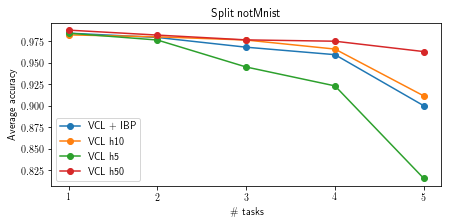

In [63]:
_ibp_acc = np.nanmean(ibp_acc, 1)
_vcl_result_h10 = np.nanmean(vcl_result, 1)
_vcl_result_h5 = np.nanmean(vcl_result_h5, 1)
_vcl_result_h50 = np.nanmean(vcl_result_h50, 1)
fig = plt.figure(figsize=(7,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h10, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('\# tasks')
ax.set_title('Split notMnist')
ax.legend()
fig.show()

In [64]:
with open('results/not_mnist.pkl', 'wb') as input_file:
    pickle.dump({'vcl_ibp': ibp_acc,
                 'vcl_h10': vcl_result,
                 'vcl_h5': vcl_result_h5,
                 'vcl_h50': vcl_result_h50}, input_file)

# Noisy MNIST

In [4]:
hidden_size = [100]
batch_size = 128
no_epochs = 500
ibp_samples = 10
learning_rate=0.0001

# Run vanilla VCL
tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
val = False
data_gen = SplitMnistRandomGenerator(val)
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
x_valsets, y_valsets = [], []
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()
    if val:
        x_train, y_train, x_test, y_test, _, _ = data_gen.next_task()
        x_valsets.append(x_val)
        y_valsets.append(y_val)
    else:
        x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, no_epochs, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = IBP_NN(in_dim, hidden_size, out_dim, x_train.shape[0], num_ibp_samples=ibp_samples,
                           prev_means=mf_weights, 
                           prev_log_variances=mf_variances, prev_betas=mf_betas, 
                           alpha0=5., beta0=1.,
                           learning_rate=learning_rate, lambda_1=1.0, lambda_2=1.0, no_pred_samples=100,
                          name='ibp_not')

    mf_model.train(x_train, y_train, head, no_epochs, bsize,
                   anneal_rate=0.0, min_temp=1.0)
    mf_weights, mf_variances, mf_betas = mf_model.get_weights()

    acc = get_scores(mf_model, x_testsets, y_testsets, single_head)
    ibp_acc = concatenate_results(acc, ibp_acc)
    
    mf_model.close_session()
    
ibp_acc

Epoch: 0001 cost= 0.238910021
Epoch: 0006 cost= 0.007571174
Epoch: 0011 cost= 0.002408872
Epoch: 0016 cost= 0.001067212
Epoch: 0021 cost= 0.000563972
Epoch: 0026 cost= 0.000294330
Epoch: 0031 cost= 0.000188392
Epoch: 0036 cost= 0.000119834
Epoch: 0041 cost= 0.000083509
Epoch: 0046 cost= 0.000060130
Epoch: 0051 cost= 0.000042397
Epoch: 0056 cost= 0.000028523
Epoch: 0061 cost= 0.000021543
Epoch: 0066 cost= 0.000016567
Epoch: 0071 cost= 0.000011915
Epoch: 0076 cost= 0.000008848
Epoch: 0081 cost= 0.000006823
Epoch: 0086 cost= 0.000004895
Epoch: 0091 cost= 0.000003711
Epoch: 0096 cost= 0.000002855
Epoch: 0101 cost= 0.000002206
Epoch: 0106 cost= 0.000001648
Epoch: 0111 cost= 0.000001324
Epoch: 0116 cost= 0.000001002
Epoch: 0121 cost= 0.000000821
Epoch: 0126 cost= 0.000000573
Epoch: 0131 cost= 0.000000466
Epoch: 0136 cost= 0.000000356
Epoch: 0141 cost= 0.000000280
Epoch: 0146 cost= 0.000000210
Epoch: 0151 cost= 0.000000164
Epoch: 0156 cost= 0.000000130
Epoch: 0161 cost= 0.000000102
Epoch: 016

AttributeError: module 'tensorflow' has no attribute 'argsort'